In [33]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

# mat = scipy.io.loadmat('C:/Users/jzhou33/Documents/Python/Biological_Learning/mnist_all.mat')
# Nc=10 # this is from 0 to 9
# N=784
# Ns=60000
# M=np.zeros((0,N))
# for i in range(Nc):
#     M=np.concatenate((M, mat['train'+str(i)]), axis=0) # the shape of mat['train'+str(i)] is xxxx by 784
# M=M/255.0 # the size of M is 60000 by 784, each example in the mnist dataset has the shape of 28x28


In [36]:
# for cifar-10
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import json
import pathlib
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

# data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # CIFAR 10 stats
])
batch_size = 50000
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10('data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True
)

Files already downloaded and verified


In [37]:
# visualize cifar data
for data in train_loader:
        inputs, label = data
cifar_data=inputs.numpy()
cifar_data.shape

(50000, 3, 32, 32)

In [59]:
N=32*32*3
Ns=50000
C=cifar_data.reshape(50000,N,order='F')

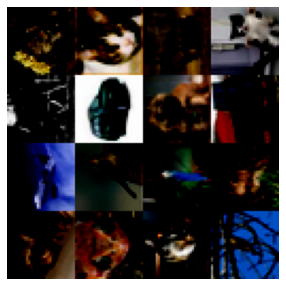

In [87]:
%matplotlib inline
#check if the cifar reshaping method is correct
fig=plt.figure(figsize=(5,5))
draw_weights(C, 4, 4)

To draw a heatmap of the weights a helper function is created:

In [88]:
from PIL import Image

def draw_weights(synapses, Kx, Ky):
    yy=0
    HM=np.zeros((32*Ky,32*Kx,3))
    for y in range(Ky):
        for x in range(Kx):
            HM[y*32:(y+1)*32,x*32:(x+1)*32,:]=synapses[yy,:].reshape(32,32,3)
            yy += 1
    plt.clf()
    #nc=np.amax(np.absolute(HM))
    #img = Image.fromarray(HM, 'RGB')
    #img.show()
    HM = np.clip(HM, 0, 1)
    im=plt.imshow(HM)
    #fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
    plt.axis('off')
    fig.canvas.draw()  
    
# def draw_weights_L2 (synapses, Kx, Ky, input_x, input_y):
#     yy=0
#     HM=np.zeros((input_y*Ky,input_x*Kx))
#     for y in range(Ky):
#         for x in range(Kx):
#             HM[y*input_y:(y+1)*input_y,x*input_x:(x+1)*input_x]=synapses[yy,:].reshape(input_y,input_x)
#             yy += 1
#     plt.clf()
#     nc=np.amax(np.absolute(HM))
#     im=plt.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
#     fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
#     plt.axis('off')
#     fig.canvas.draw()  

This cell defines paramaters of the algorithm: `eps0` - initial learning rate that is linearly annealed during training; `hid` - number of hidden units that are displayed as an `Ky` by `Kx` array by the helper function defined above; `mu` - the mean of the gaussian distribution that initializes the weights; `sigma` - the standard deviation of that gaussian; `Nep` - number of epochs; `Num` - size of the minibatch; `prec` - parameter that controls numerical precision of the weight updates; `delta` - the strength of the anti-hebbian learning; `p` - Lebesgue norm of the weights; `k` - ranking parameter. 

In [91]:
eps0=4e-2    # learning rate
Kx=40
Ky=50
hid=Kx*Ky    # number of hidden units that are displayed in Ky by Kx array
Kx_L2=10
Ky_L2=10
hid_L2 = Kx_L2*Ky_L2
mu=0.0
sigma=1.0
Nep=200      # number of epochs
Num=100      # size of the minibatch
prec=1e-30
delta=0.4    # Strength of the anti-hebbian learning
delta_L2=0.4    # Strength of the anti-hebbian learning
p=3        # Lebesgue norm of the weights
k=2          # ranking parameter, must be integer that is bigger or equal than 2

This cell defines the main code. The external loop runs over epochs `nep`, the internal loop runs over minibatches. For every minibatch the overlap with the data `tot_input` is calculated for each data point and each hidden unit. The sorted strengths of the activations are stored in `y`. The variable `yl` stores the activations of the post synaptic cells - it is denoted by g(Q) in Eq 3 of [Unsupervised Learning by Competing Hidden Units](https://doi.org/10.1073/pnas.1820458116), see also Eq 9 and Eq 10. The variable `ds` is the right hand side of Eq 3. The weights are updated after each minibatch in a way so that the largest update is equal to the learning rate `eps` at that epoch. The weights are displayed by the helper function after each epoch. 

<IPython.core.display.Javascript object>


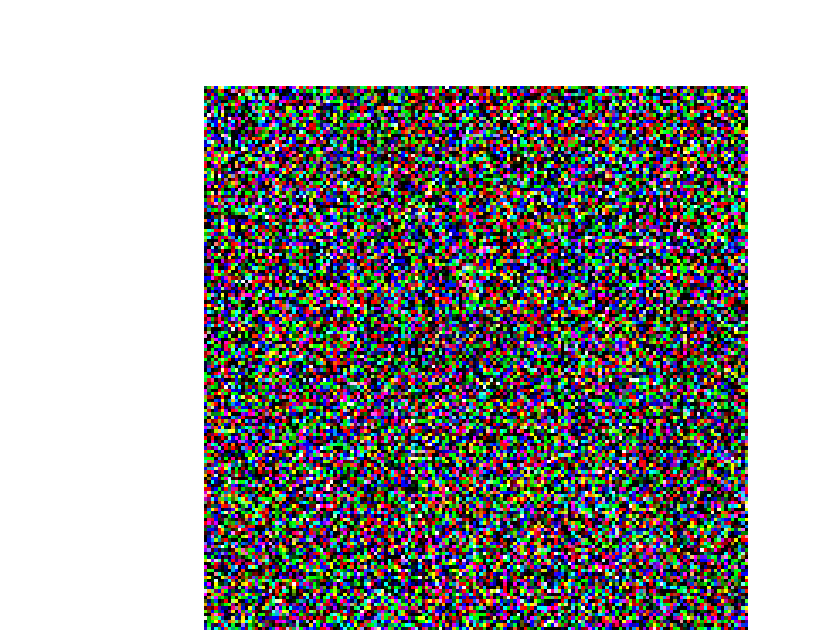

0


In [ ]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12.9,10))

synapses = np.random.normal(mu, sigma, (hid, N))
# synapses_L2 = np.random.normal(mu, sigma, (hid_L2, hid))
for nep in range(Nep):
    eps=eps0*(1-nep/Nep)
    C=C[np.random.permutation(Ns),:]
    for i in range(Ns//Num):
        inputs=np.transpose(C[i*Num:(i+1)*Num,:]) # the size of C is 50000 by 32*32*3 
        sig=np.sign(synapses)
        tot_input=np.dot(sig*np.absolute(synapses)**(p-1),inputs) # size is hidden dimension by 100 (minibatch)
        y=np.argsort(tot_input,axis=0)
        yl=np.zeros((hid,Num))
        yl[y[hid-1,:],np.arange(Num)]=1.0
        yl[y[hid-k],np.arange(Num)]=-delta
        xx=np.sum(np.multiply(yl,tot_input),1)
        ds=np.dot(yl,np.transpose(inputs)) - np.multiply(np.tile(xx.reshape(xx.shape[0],1),(1,N)),synapses)
        nc=np.amax(np.absolute(ds))
        if nc<prec:
            nc=prec
        synapses += eps*np.true_divide(ds,nc)  
        
#         inputs_L2=tot_input
#         #inputs_L2 = yl #the hidden layer output passed through the nonlinear activation function
#         sig=np.sign(synapses_L2)
#         tot_input_L2=np.dot(sig*np.absolute(synapses_L2)**(p-1),inputs_L2) # 20 (hidden dimension) by 100 (minibatch)
#         y=np.argsort(tot_input_L2,axis=0)
#         yl_L2=np.zeros((hid_L2,Num))
#         yl_L2[y[hid_L2-1,:],np.arange(Num)]=1.0
#         yl_L2[y[hid_L2-k],np.arange(Num)]=-delta_L2
#         xx=np.sum(np.multiply(yl_L2,tot_input_L2),1)
#         ds=np.dot(yl_L2,np.transpose(inputs_L2)) - np.multiply(np.tile(xx.reshape(xx.shape[0],1),(1,hid)),synapses_L2)
#         nc=np.amax(np.absolute(ds))
#         if nc<prec:
#             nc=prec
#         synapses_L2 += eps*np.true_divide(ds,nc)

    draw_weights(synapses, 5, 5)